In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# MF
矩阵分解中，把用户和电影单独转换为3维度Embedding的矩阵
然后分别打扁后，然后相乘为U-I矩阵
https://nipunbatra.github.io/blog/ml/2017/12/18/recommend-keras.html

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
dataset = pd.read_csv('/content/drive/My Drive/PY/RecSys/ratings.csv') # rating_small
# ratings = pd.read_csv('ml-latest/ratings.csv')    
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
n_users, n_movies = len(dataset.userId.unique()), len(dataset.movieId.unique())
dataset.userId = dataset.userId.astype('category').cat.codes.values
dataset.movieId = dataset.movieId.astype('category').cat.codes.values

n_latent_factors = 3
print(n_users, n_movies)


Using TensorFlow backend.


610 9724


In [ ]:
train, test = train_test_split(dataset, test_size=0.3)
train.head()

,userId,movieId,rating,timestamp
77203,481,5356,1.0,1105397218
5205,33,1345,3.0,1162048144
52208,338,6294,2.5,1460183593
25738,176,7670,4.0,1435526646
68751,447,511,4.0,1019126687


In [ ]:
from keras.layers import *
from keras.models import Model

movie_input = Input(shape=[1],name='Item')
movie_embedding = Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

user_input = Input(shape=[1],name='User')
user_embedding = Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)
prod = dot([movie_vec, user_vec], (1),name='DotProduct')
model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')
model.summary()





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         29175       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         1833        User[0][0]                       
________________________________________________________________________________________

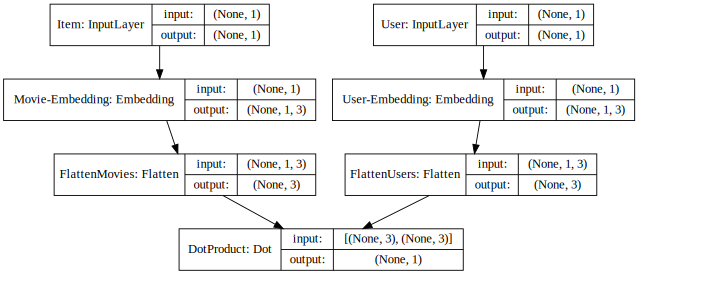

In [ ]:
SVG(model_to_dot(model,show_shapes=True, show_layer_names=True, rankdir='HB', dpi=65).create(prog='dot', format='svg'))

In [ ]:
history = model.fit([train.userId, train.movieId], train.rating, epochs=50)




Epoch 1/50





70585/70585 [==============================] - 13s 186us/step - loss: 12.7295
Epoch 2/50
70585/70585 [==============================] - 9s 127us/step - loss: 7.6380
Epoch 3/50
70585/70585 [==============================] - 8s 118us/step - loss: 4.0447
Epoch 4/50
70585/70585 [==============================] - 9s 126us/step - loss: 2.6873
Epoch 5/50
70585/70585 [==============================] - 8s 120us/step - loss: 1.9926
Epoch 6/50
70585/70585 [==============================] - 9s 122us/step - loss: 1.5885
Epoch 7/50
70585/70585 [==============================] - 8s 119us/step - loss: 1.3341
Epoch 8/50
70585/70585 [==============================] - 9s 121us/step - loss: 1.1639
Epoch 9/50
70585/70585 [==============================] - 8s 120us/step - loss: 1.0451
Epoch 10/50
70585/70585 [==============================] - 8s 120us/step - loss: 0.9595
Epoch 11/50
70585/70585 [==============================] - 8s 120us/step - loss: 0.8956
Epoch 12/50
70585/70585 [======

Text(0, 0.5, 'Train Error')

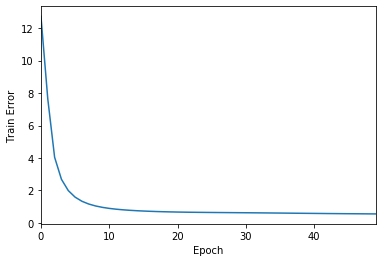

In [ ]:
pd.Series(history.history['loss']).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [ ]:
y_hat = np.round(model.predict([test.userId, test.movieId]),2)
y_true = test.rating
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat) #MAE

0.7996562090051682

## 提取Embedding

In [ ]:
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2
count,9725.000000,9725.000000,9725.000000
mean,0.531592,-0.549229,-0.541133
std,0.285085,0.286370,0.289282
min,-0.202563,-1.611653,-1.670261
25%,0.372724,-0.742796,-0.739415
50%,0.584850,-0.604589,-0.595220
75%,0.732400,-0.412202,-0.397301
max,1.411002,0.243995,0.518249


In [ ]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt)

,0,1,2
0,1.915152,-1.829822,-3.011091
1,1.475469,-2.052975,-1.839297
2,1.400968,-1.825551,-0.274014
3,1.116854,-2.182864,-2.041183
4,1.832540,-1.841085,-1.953935
...,...,...,...
606,1.924117,-2.054359,-1.686039
607,1.620187,-1.523207,-1.873387
608,1.543361,-1.537603,-1.920058
609,2.731951,-1.603161,-1.509870


# Non-negative Matrix factorisation (NNMF)
Embedding中为非负数

In [ ]:
from keras.constraints import non_neg
movie_input = Input(shape=[1],name='Item')
movie_embedding = Embedding(n_movies + 1, n_latent_factors, name='NonNegMovie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_Embedding = Embedding(n_users + 1, n_latent_factors,name='NonNegUser-Embedding',embeddings_constraint=non_neg())(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_Embedding)

prod = dot([movie_vec, user_vec],(1),name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
NonNegMovie-Embedding (Embeddin (None, 1, 3)         29175       Item[0][0]                       
__________________________________________________________________________________________________
NonNegUser-Embedding (Embedding (None, 1, 3)         1833        User[0][0]                       
____________________________________________________________________________________________

In [ ]:
history_nonneg = model.fit([train.userId, train.movieId], train.rating, epochs=10, verbose=1)

Epoch 1/10
70585/70585 [==============================] - 9s 125us/step - loss: 11.7454
Epoch 2/10
70585/70585 [==============================] - 9s 123us/step - loss: 6.3813
Epoch 3/10
70585/70585 [==============================] - 9s 123us/step - loss: 3.5876
Epoch 4/10
70585/70585 [==============================] - 9s 122us/step - loss: 2.4483
Epoch 5/10
70585/70585 [==============================] - 9s 123us/step - loss: 1.8407
Epoch 6/10
70585/70585 [==============================] - 9s 124us/step - loss: 1.4817
Epoch 7/10
70585/70585 [==============================] - 9s 124us/step - loss: 1.2532
Epoch 8/10
70585/70585 [==============================] - 9s 123us/step - loss: 1.1005
Epoch 9/10
70585/70585 [==============================] - 9s 123us/step - loss: 0.9939
Epoch 10/10
70585/70585 [==============================] - 9s 121us/step - loss: 0.9166


In [ ]:
user_embedding_learnt = model.get_layer(name='NonNegUser-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe() #Embedding 没有负的了

,0,1,2
count,611.000000,611.000000,611.000000
mean,1.725912,1.730634,1.722005
std,0.250653,0.251124,0.250040
min,-0.000000,-0.000000,0.041254
25%,1.586456,1.591024,1.583274
50%,1.749195,1.748769,1.738054
75%,1.901385,1.900050,1.889395
max,2.447897,2.446124,2.463590


# DL for RecSys
Embedding不相乘，而是拼接起来，当传统DNN做

In [ ]:
n_latent_factors_user = 5
n_latent_factors_movie = 8

movie_input = Input(shape=[1],name='Item')
movie_embedding = Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = Dropout(0.2, name='Dropout_movie')(movie_vec)


user_input = Input(shape=[1],name='User')
user_Embedding = Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_Embedding)
user_vec = Dropout(0.2, name='Dropout_user')(user_vec)


concat = concatenate([movie_vec, user_vec], name='Concat')
concat = Dropout(0.2, name='Dropout_concat')(concat)

dense = Dense(200,name='FullyConnected')(concat)
# dense = Dropout(0.2, name='Dropout')(dense)
dense_2 = Dense(100, name='FullyConnected-1')(dense)
# dense_2 = Dropout(0.2, name='Dropout2')(dense_2)
dense_3 = Dense(50, name='FullyConnected-2')(dense_2)
# dense_3 = Dropout(0.2, name='Dropout3')(dense_3)
dense_4 = Dense(20, name='FullyConnected-3', activation='relu')(dense_3)


result = Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 8)         77800       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         3055        User[0][0]

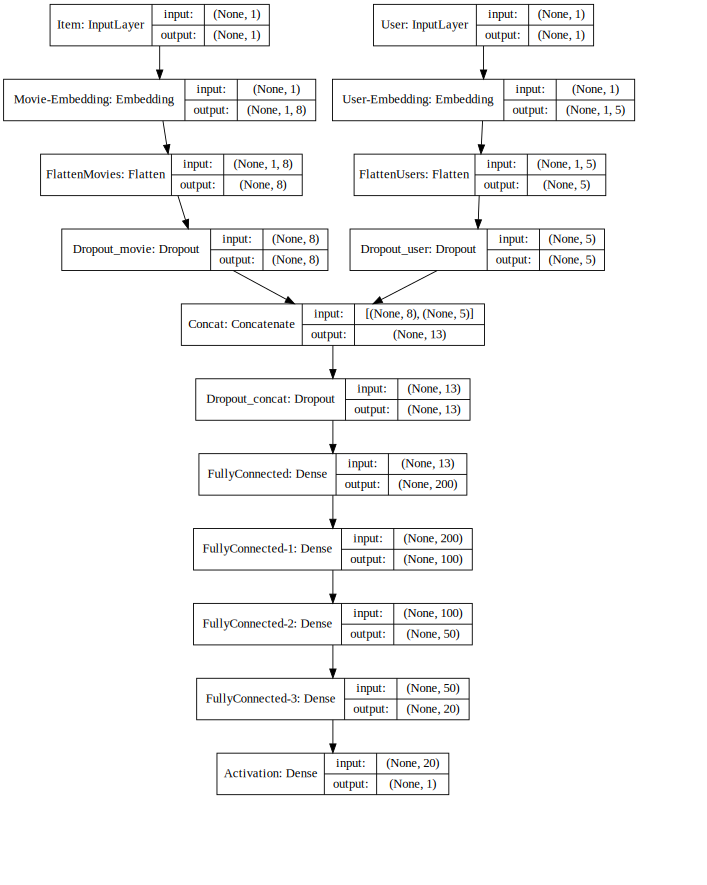

In [ ]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB', dpi=65).create(prog='dot', format='svg'))

In [ ]:
history = model.fit([train.userId, train.movieId], train.rating, epochs=20, verbose=1)

Text(0, 0.5, 'Train Error')

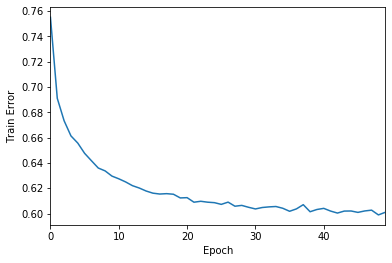

In [ ]:
pd.Series(history.history['loss']).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [ ]:
y_hat_2 = np.round(model.predict([test.userId, test.movieId]),2)
print(mean_absolute_error(y_true, y_hat_2))

0.9524501712149791


# Autoencoder+FC

In [ ]:
n_latent_factors_user = 3
n_latent_factors_movie = 3

movie_input = Input(shape=[1],name='Item')
movie_embedding = Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)
# movie_vec = Dropout(0.2, name='Dropout_movie')(movie_vec)


user_input = Input(shape=[1],name='User')
user_Embedding = Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_Embedding)
# user_vec = Dropout(0.2, name='Dropout_user')(user_vec)


concat = concatenate([movie_vec, user_vec], name='Concat')


dense = Dense(100, activation='relu', name='FullyConnected-1')(concat)

result = Dense(50, activation='relu', name='FullyConnected-2')(dense)

Model_enc = Model([user_input, movie_input], result)
Model_enc.compile(
    optimizer='adam',
    loss = 'binary_crossentropy'#,'mean_absolute_error'  #y要打散成10位one hot， 更稳定 不易过拟合
)

Model_enc.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         29175       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         1833        User[0][0]                       
___________________________________________________________________________________________

In [ ]:
x = bottleneck = Input(shape=(50,))
x = Dense(100, activation='relu')(x)
y1 = Dense(1, activation='relu')(x)
y2 = Dense(1, activation='relu')(x)


Model_dec = Model(bottleneck, [y1, y2])
Model_dec.compile(optimizer='adam', loss='binary_crossentropy')
Model_dec.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 100)          5100        input_7[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 1)            101         dense_16[0][0]                   
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 1)            101         dense_16[0][0]                   
Total params: 5,302
Trainable params: 5,302
Non-trainable params: 0
_______________________

In [ ]:
reconstruction = Model_dec(Model_enc.output)
# y1 = Lambda(lambda x: x[0:1])(reconstruction) 如果自动编码生成的结果是已经concat到一起的
Model_autoencoder = Model(Model_enc.input, reconstruction) #.output只是代入值，不能作为layer来直接引用
Model_autoencoder.compile(optimizer='adam', loss='mean_absolute_error')
Model_autoencoder.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         29175       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         1833        User[0][0]                       
___________________________________________________________________________________________

In [ ]:
history = Model_autoencoder.fit([train.userId, train.movieId], [train.userId, train.movieId], epochs=20)

Epoch 1/20
70585/70585 [==============================] - 16s 226us/step - loss: 31.5571 - model_22_loss: 29.8429
Epoch 2/20
70585/70585 [==============================] - 16s 221us/step - loss: 31.4116 - model_22_loss: 29.7074
Epoch 3/20
70585/70585 [==============================] - 16s 225us/step - loss: 31.2053 - model_22_loss: 29.4820
Epoch 4/20
70585/70585 [==============================] - 16s 223us/step - loss: 31.0157 - model_22_loss: 29.2683
Epoch 5/20
70585/70585 [==============================] - 16s 228us/step - loss: 30.7464 - model_22_loss: 29.0219
Epoch 6/20
70585/70585 [==============================] - 16s 225us/step - loss: 30.5310 - model_22_loss: 28.7670
Epoch 7/20
70585/70585 [==============================] - 16s 227us/step - loss: 30.6268 - model_22_loss: 28.9119
Epoch 8/20
70585/70585 [==============================] - 16s 224us/step - loss: 30.0571 - model_22_loss: 28.3673
Epoch 9/20
70585/70585 [==============================] - 16s 227us/step - loss: 30.0540

Text(0, 0.5, 'Train Error')

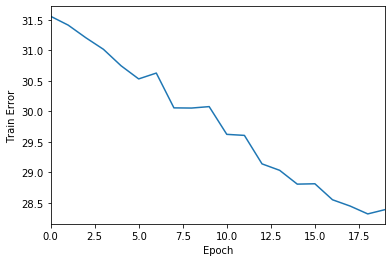

In [ ]:
pd.Series(history.history['loss']).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [ ]:
#导出模型
Model_autoencoder.save('Model_autoencoder.model')
Model_enc.save('Model_enc.model')
Model_dec.save('Model_dec.model')

In [ ]:
#导入模型
from keras.models import load_model
# cd '/content/drive/My Drive/PY/RecSys'
Model_autoencoder = load_model('Model_autoencoder.model')
Model_enc = load_model('Model_enc.model')
Model_dec = load_model('Model_dec.model')










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
train.iloc[[0]]

,userId,movieId,rating,timestamp
23441,159,1450,1.0,976797780


In [ ]:
Model_enc.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         29175       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         1833        User[0][0]                       
___________________________________________________________________________________________

In [ ]:
Model_dec.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 100)          5100        input_7[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 1)            101         dense_16[0][0]                   
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 1)            101         dense_16[0][0]                   
Total params: 5,302
Trainable params: 5,302
Non-trainable params: 0
_______________________

In [ ]:
medium = Model_enc.predict([np.array([159]), np.array([1450])])
medium.shape

(1, 50)

In [ ]:
medium

array([[4.8455405, 0.       , 4.347558 , 0.       , 3.3903902, 4.4237905,
        3.2434504, 4.5424376, 4.712517 , 4.872182 , 0.       , 5.0264807,
        4.2754846, 2.671499 , 3.7223287, 4.7612357, 0.       , 3.0336761,
        4.573631 , 5.7807117, 0.       , 4.4891586, 4.85463  , 2.64744  ,
        4.8302903, 3.3727763, 0.       , 0.6732986, 1.7867565, 2.120853 ,
        0.       , 3.5811484, 4.039042 , 2.6725504, 0.       , 2.651541 ,
        0.       , 2.9360347, 2.658218 , 5.23965  , 3.5662591, 0.       ,
        2.6192544, 5.8197255, 5.2398424, 4.127639 , 5.749321 , 4.8358116,
        5.46509  , 0.       ]], dtype=float32)

In [ ]:
Model_autoencoder.predict([np.array([159]), np.array([1450])])

[array([[161.67424]], dtype=float32), array([[1452.5198]], dtype=float32)]

## Extract Embedding


提取Embedding (,3) user 和 movie分别用3维的权重来表示

也可提取中间层的权重（，50）用50维度的来作为u/i的joint representation

In [ ]:
movie_embedding = Model_enc.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding).describe()

,0,1,2
count,9725.000000,9725.000000,9725.000000
mean,0.007176,0.011087,0.013080
std,0.317705,0.316924,0.324139
min,-0.588074,-0.588380,-0.589620
25%,-0.214737,-0.214859,-0.216787
50%,-0.007767,-0.006572,-0.005644
75%,0.170381,0.196951,0.182475
max,1.288414,1.228917,1.877515


autoencoder尝试加入卷积层

## 使用Autoencoder的中间层预测

In [ ]:
medium_train = Model_enc.predict([train.userId, train.movieId])
medium_train.shape

(70585, 50)

In [ ]:
x = Input(shape=(50,))
dense = Dense(200,name='FullyConnected', activation='relu')(x)
dense_2 = Dense(50, name='FullyConnected-2', activation='relu')(dense)

result = Dense(1, activation='elu')(dense_2)
model = Model(x, result)
model.compile(optimizer='adam', loss= 'mean_absolute_error')
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 50)                0         
_________________________________________________________________
FullyConnected (Dense)       (None, 200)               10200     
_________________________________________________________________
FullyConnected-2 (Dense)     (None, 50)                10050     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 20,301
Trainable params: 20,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(medium_all, train.rating, epochs=20)

Epoch 1/20
70585/70585 [==============================] - 10s 136us/step - loss: 0.8890
Epoch 2/20
70585/70585 [==============================] - 9s 125us/step - loss: 0.8532
Epoch 3/20
70585/70585 [==============================] - 9s 127us/step - loss: 0.8420
Epoch 4/20
70585/70585 [==============================] - 9s 125us/step - loss: 0.8380
Epoch 5/20
70585/70585 [==============================] - 9s 124us/step - loss: 0.8336
Epoch 6/20
70585/70585 [==============================] - 9s 127us/step - loss: 0.8310
Epoch 7/20
70585/70585 [==============================] - 9s 124us/step - loss: 0.8263
Epoch 8/20
70585/70585 [==============================] - 9s 128us/step - loss: 0.8229
Epoch 9/20
70585/70585 [==============================] - 9s 128us/step - loss: 0.8221
Epoch 10/20
70585/70585 [==============================] - 9s 125us/step - loss: 0.8205
Epoch 11/20
70585/70585 [==============================] - 9s 126us/step - loss: 0.8194
Epoch 12/20
70585/70585 [===============

In [ ]:
medium_test = Model_enc.predict([test.userId, test.movieId])
y_predict = np.round(model.predict(medium_test,2))
print(mean_absolute_error(test.rating, y_predict))

0.8358566658953424


# QuesTest

In [ ]:
# np.random.randint(10,size=8)
horses = [np.random.randint(1,100, size=8) for i in range(8)]
horses
# horses = [i for r in horses for i in r]

[array([35, 48, 56, 18, 96, 84, 92, 68]),
 array([90, 43, 56, 90, 93, 23, 16, 52]),
 array([33, 61, 51, 37, 47, 78, 54, 13]),
 array([27, 75, 87, 92, 12, 44, 79, 82]),
 array([29, 28, 17, 32, 65, 38, 26, 54]),
 array([83, 77, 65, 21, 32, 89, 90, 63]),
 array([90, 87, 23, 54, 67, 30, 57, 26]),
 array([ 5, 50, 50, 61, 45,  5, 30, 45])]

In [ ]:
# horses = np.array([[9,8,7,6,6,4,3,4],
#           [8,5,2,2,5,1,2,3],
#           [1,2,3,2,1,2,2,3],
#           [1,6,9,1,0,2,3,2],
#           [2, 9, 1, 2, 8, 7, 1, 2], 
#           [5, 8, 6, 3, 3, 1, 7, 0],
#           [1, 5, 1, 4, 2, 0, 0, 1],
#           [1, 7, 1, 7, 0, 6, 4, 7],
# ])
horses = [i for r in horses for i in r]
def top4(h):
#   flat = [i for r in h for i in r]
  res = np.sort(h)
  return res[::-1][:4]

print(top4(horses))

def runH(l):
#   l.sort(reverse=True)
  res = np.sort(l)[::-1]
  global iteration
  iteration += 1
  return res

[96 93 92 92]


In [ ]:
## 当前4匹最快进行迭代
iteration = 0
Top4 = []
for h in horses:
  if len(Top4) < 8:  #填充新的4匹马凑8
    Top4 = np.append(Top4,h)
  elif len(Top4) == 8:
    temp = runH(Top4)
    Top4 = temp[:4]
    print("第{}回合".format(iteration),temp)
    Top4 = np.append(Top4,h)
temp = runH(Top4)
Top4 = temp[:4]
print("第{}回合".format(iteration),temp)
print(Top4, iteration)

第1回合 [96. 92. 84. 68. 56. 48. 35. 18.]
第2回合 [96. 92. 90. 90. 84. 68. 56. 43.]
第3回合 [96. 93. 92. 90. 90. 52. 23. 16.]
第4回合 [96. 93. 92. 90. 61. 51. 37. 33.]
第5回合 [96. 93. 92. 90. 78. 54. 47. 13.]
第6回合 [96. 93. 92. 92. 90. 87. 75. 27.]
第7回合 [96. 93. 92. 92. 82. 79. 44. 12.]
第8回合 [96. 93. 92. 92. 32. 29. 28. 17.]
第9回合 [96. 93. 92. 92. 65. 54. 38. 26.]
第10回合 [96. 93. 92. 92. 83. 77. 65. 21.]
第11回合 [96. 93. 92. 92. 90. 89. 63. 32.]
第12回合 [96. 93. 92. 92. 90. 87. 54. 23.]
第13回合 [96. 93. 92. 92. 67. 57. 30. 26.]
第14回合 [96. 93. 92. 92. 61. 50. 50.  5.]
第15回合 [96. 93. 92. 92. 45. 45. 30.  5.]
[96. 93. 92. 92.] 15


In [ ]:
## 选当前最快3匹马迭代
iteration = 0
# Top3 = runH(horses[0:8])[:3]
Top3 = []
No4 = []
for h in horses:
  if len(Top3) < 8:   #填充新的5匹马凑8
    Top3 = np.append(Top3, h)
  elif len(Top3) == 8:
    temp = runH(Top3)
    Top3 = temp[:3]
    No4.append(temp[3])
    print("第{}回合".format(iteration),temp)
    Top3 = np.append(Top3,h)
extra = Top3[3]
# temp = runH(Top3)
# Top3 = temp[:3]
# No4.append(temp[3])
print(Top3[:3],extra)

No4 = np.append(No4,extra)
print("前12回合的第4和多余的一个：",No4)
iteration += np.ceil(len(No4)/8)
No4 = np.sort(No4)[-1]
print('13匹马竞争第四，回合数+2')

print("前三: ",Top3[:3],'第四：', No4,'总回合数：', iteration)

第1回合 [96. 92. 84. 68. 56. 48. 35. 18.]
第2回合 [96. 93. 92. 90. 90. 84. 56. 43.]
第3回合 [96. 93. 92. 61. 52. 33. 23. 16.]
第4回合 [96. 93. 92. 78. 54. 51. 47. 37.]
第5回合 [96. 93. 92. 92. 87. 75. 27. 13.]
第6回合 [96. 93. 92. 82. 79. 44. 29. 12.]
第7回合 [96. 93. 92. 65. 38. 32. 28. 17.]
第8回合 [96. 93. 92. 83. 77. 65. 54. 26.]
第9回合 [96. 93. 92. 90. 89. 63. 32. 21.]
第10回合 [96. 93. 92. 90. 87. 67. 54. 23.]
第11回合 [96. 93. 92. 57. 50. 30. 26.  5.]
第12回合 [96. 93. 92. 61. 50. 45. 30.  5.]
[96. 93. 92.] 45.0
前12回合的第4和多余的一个： [68. 90. 61. 78. 92. 82. 65. 83. 90. 90. 57. 61. 45.]
13匹马竞争第四，回合数+2
前三:  [96. 93. 92.] 第四： 92.0 总回合数： 14.0


2.0